## Preprocessing Dyamond

Converting the data into npy makes it possible for us to work with it efficiently; originally we require 500GB of RAM which is always difficult to guarantee.

1) We read the data
2) Reshape variables so that they have equal dimensionality
3) Remove data above 21kms
4) Reshape into data samples fit for the NN
5) Split into input and output
6) Save as npy in float32

Note: We neither scale nor split the data into training/validation/test sets. <br>
The reason is that i) in order to scale we need the entire dataset but this can only be done in conjunction with the Narval dataset. Also for cross-validation different scalings will be necessary based on different subsets of the data, ii) The split into subsets will be done by the cross-validation procedure or not at all when training the final model.

In [1]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gc 
# import importlib
# importlib.reload(my_classes)

base_path = '/home/b/b309170'
output_path = base_path + '/my_work/icon-ml_data/cloud_cover_parameterization/grid_column_based_DYAMOND/'

# Add path with my_classes to sys.path
sys.path.insert(0, base_path + '/workspace_icon-ml/cloud_cover_parameterization/')

from my_classes import load_data

VERT_LAYERS = 31

# ['all', 'discard_spinup']
days = 'discard_spinup'

#Set a numpy seed for the permutation later on!
np.random.seed(10)

## 1) Reading the data
### Input:
- fr_land: Fraction of land
- zg: Geometric height at full levels (3D)
- qv: Specific water vapor content (3D)
- qc: Specific cloud water content (3D)
- qi: Specific cloud ice content (3D)
- temp: Temperature (3D)
- pres: Pressure (3D)

$186$ $( = 1+24[zf]+26[q_c]+27\cdot 5$) input nodes

### Output:
- clc: Cloud Cover

$27$ output nodes

The data above 21km is capped.

In [2]:
# For cl_area I only need the output as I already have the input
# I still need 'clw', 'cli', 'cl' for condensate-free clouds
# If I were to use 'cl_area' for condensate-free clouds I would get an estimate 
# which is slightly different due to coarse-graining
order_of_vars_dyamond = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'clc', 'cl_area']

In [3]:
# Load dyamond data
data_dict = load_data(source='split_by_var_name', days=days, resolution='R02B05', order_of_vars=order_of_vars_dyamond,
                      path='/home/b/b309170/bd1179_work/DYAMOND/hvcg_data')

hus
clw
cli
ta
pa
clc
cl_area


In [4]:
ta_is_0 = np.where(data_dict['ta'] == 0)
for i in range(3):
    assert ta_is_0[i].size == 0
    
del ta_is_0
gc.collect()

4416

In [10]:
for key in data_dict.keys():
    print(key, data_dict[key].shape)

hus (467, 31, 79342)
clw (467, 31, 79342)
cli (467, 31, 79342)
ta (467, 31, 79342)
pa (467, 31, 79342)
zg (467, 31, 79342)
fr_land (467, 79342)
clc (467, 31, 79342)
cl_area (467, 31, 79342)


In [6]:
(TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = data_dict['clc'].shape

In [7]:
try:
    #Reshaping into nd-arrays of equaling shapes (don't reshape in the vertical)
    data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), TIME_STEPS, axis=0)
    data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 0), TIME_STEPS, axis=0)
except:
    pass

In [8]:
# Remove the first timesteps of the dyamond simulations since the clc values are 0 across the entire earth there 
remove_steps = []
for i in range(data_dict['clc'].shape[0]):
    if np.all(data_dict['clc'][i,4:,:] == 0):
        remove_steps.append(i)
        TIME_STEPS = TIME_STEPS - 1

for key in data_dict.keys():
    data_dict[key] = np.delete(data_dict[key], remove_steps, axis=0)
    
remove_steps

[]

In [9]:
# Our Neural Network has trained with clc in [0, 100]!
data_dict['clc'] = 100*data_dict['clc']
data_dict['cl_area'] = 100*data_dict['cl_area']
print(np.max(data_dict['clc'][:, 4:, :]))
print(np.max(data_dict['cl_area'][:, 4:, :]))

100.00001192092896
100.00000000000048


In [10]:
# One sample should contain a column of information
data_dict_reshaped = {}

for key in data_dict.keys():
    if data_dict[key].shape[1] == VERT_LAYERS:  
        # Removing data above 21kms
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',(i+17)) # Should start at 21
            data_dict_reshaped[new_key] = np.reshape(data_dict[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict[key], -1)

In [11]:
#Modifies df as well
def split_input_output(dataset):
    output_clc = {}
    output_cl_area = {}
    for i in range(21, 48):
        output_cl_area['cl_area_%d'%i] = dataset['cl_area_%d'%i] # Should start at 21
        output_clc['clc_%d'%i] = dataset['clc_%d'%i] # Should start at 21
        del dataset['cl_area_%d'%i]
        del dataset['clc_%d'%i]
    return output_clc, output_cl_area

In [12]:
output_clc, output_cl_area = split_input_output(data_dict_reshaped)

In [13]:
# Convert dict into np array
data_reshaped = np.array([data_dict_reshaped[j] for j in data_dict_reshaped.keys()])
output_clc_np = np.array([output_clc[j] for j in output_clc.keys()])
output_cl_area_np = np.array([output_cl_area[j] for j in output_cl_area.keys()])

In [14]:
# Save the data
np.save(output_path + '/cloud_cover_input_dyamond.npy', np.float32(data_reshaped))
np.save(output_path + '/cloud_cover_output_dyamond.npy', np.float32(output_clc_np))
np.save(output_path + '/cloud_area_output_dyamond.npy', np.float32(output_cl_area_np))

Some tests of the cloud area output

In [34]:
diff = output_cl_area_np - output_clc_np

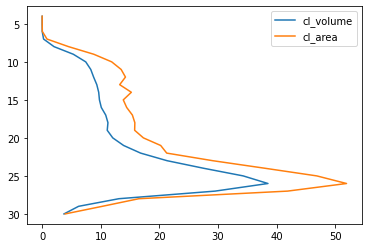

In [13]:
a = np.arange(4, 31)
plt.plot(np.mean(output_clc_np, axis=1), a)
plt.plot(np.mean(output_cl_area_np, axis=1), a)
plt.legend(['cl_volume', 'cl_area'])
plt.gca().invert_yaxis()

In [9]:
# These should be anomalies existing due to differences in coarse-graining
len(np.where(diff < 0)[0])

11571909

In [10]:
len(np.where(diff >= 0)[0])

1314470937

In [11]:
len(np.where(diff < 0)[0])/diff.size # 0.8% of the data

0.008726647886911491

In [12]:
len(np.where(diff < 0)[0])/len(np.where(diff != 0)[0]) #2.3% of cloudy data

0.02285209067842502

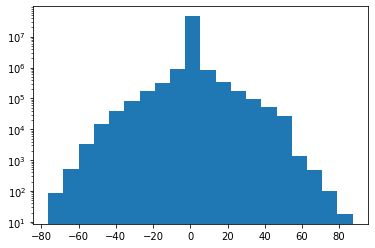

In [15]:
plt.hist(diff[-1], bins = 20, log=True)
plt.show()